In [53]:
import os
import pandas
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [3]:
# Custom Dataset
class DetectDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        
        image = Image.open(img_path).convert("RGB")
        
        # get labels box coordinates
        boxes = []
        labels = []
        
        # parse the label path and read files
        with open(label_path, 'r') as file:
            for line in file.readlines():
                # Grab label variables from file
                class_id, x_center, y_center, width, height = map(float, line.strip().split()) # returns list of float from split line
                
                # Convert normalized coordinates to pixel coordinates
                x_center *= image.width
                y_center *= image.height
                width *= image.width
                height *= image.height
                
                # Calculate bounding box corners
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2
                
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Dictionary of box coordinates & labels
        target = {"boxes": boxes, "labels": labels} 
            
        return image, target

In [4]:
# Variable Length Data: Each image can have a different number of bounding boxes. 
# The default collate_fn tries to stack everything into tensors, which fails if they have different shapes.

# Stack images into tensors but not targets to avoid this conflict
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        images.append(sample[0])
        targets.append(sample[1])
    images = torch.stack(images, dim=0)
    return images, targets

In [5]:
classes = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [6]:
train_labels_dir = "../data/VehiclesDetectionDataset/train/labels/"
train_img_dir = "../data/VehiclesDetectionDataset/train/images/"
test_labels_dir = "../data/VehiclesDetectionDataset/test/labels/"
test_img_dir = "../data/VehiclesDetectionDataset/test/images/"

In [7]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor()
])

In [12]:
trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
# issue with torch.stack when batch > 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [13]:
testset = DetectDataset(test_labels_dir, test_img_dir, transform=transform)
# issue with torch.stack when batch > 1
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)

In [31]:
train_features, train_labels = next(iter(trainloader))

In [56]:
train_features.shape

torch.Size([4, 3, 250, 250])

In [59]:
train_labels

[{'boxes': tensor([[184.5000, 172.7500, 246.5000, 341.2500]]),
  'labels': tensor([3])},
 {'boxes': tensor([[ 42.5000,  12.0000, 349.5000, 395.0000]]),
  'labels': tensor([1])},
 {'boxes': tensor([[163.0000,  41.7500, 311.0000, 135.2500]]),
  'labels': tensor([4])},
 {'boxes': tensor([[ 45.5000, 237.2500, 186.5000, 411.7500]]),
  'labels': tensor([3])}]

Class ID: 3
Box Coordinates: 184.5
Box Coordinates: 172.75
Box Coordinates: 246.5
Box Coordinates: 341.25
torch.Size([250, 250, 3])


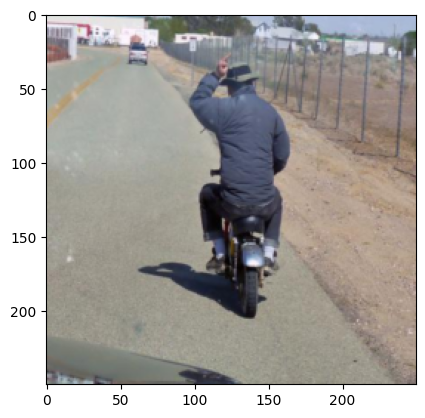

In [69]:
print(f"Class ID: {train_labels[0]['labels'][0]}")
for box in train_labels[0]['boxes'][0]: print(f"Box Coordinates: {box}")
img = train_features[0]
img = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img)
plt.show()

In [80]:
# Convert tensor image to correct openCV image format
def tensor_to_cv2_image(tensor):
    # Convert GPU tensor to CPU based
    image = tensor.cpu().numpy() 
    image = (image * 255) # convert to unnormalized pixel values
    image = np.ascontiguousarray(image, np.uint8)
    return image

# Draw boxes on image
def draw_boxes(image, boxes, labels):
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = map(int, box)
        cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv.putText(image, str(int(label)), (x_min, y_min - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

In [81]:
# Convert image tensor to openCV image
image = tensor_to_cv2_image(img)
print("Image Type:", image.shape)

target = train_labels[0]
boxes = target['boxes']
labels = target['labels']

# Draw box on image
image = draw_boxes(image, boxes, labels)

Image Type: (250, 250, 3)


In [84]:
# Make window bigger and show image
cv.namedWindow("window", cv.WINDOW_NORMAL)
cv.resizeWindow("window", 800, 600)
cv.imshow("window", image)
cv.waitKey(0) # press key to close

-1